## **IMPORT LIBRARIES**

In [6]:
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import wavfile
import scipy.signal as signal

from IPython.display import Audio

## **AUDIO PLOTTER**

In [7]:
def plot_overlay_waveform(y_input, y_denoised, sr, title="Audio Comparison"):

    # Ensure same length
    min_len = min(len(y_input), len(y_denoised))
    y_input = y_input[:min_len]
    y_denoised = y_denoised[:min_len]

    # Time axis
    t = np.arange(min_len) / sr

    # Plot overlay
    plt.figure(figsize=(12, 4))
    plt.plot(t, y_input, alpha=0.6, label="Input (Noisy)", color="red")
    plt.plot(t, y_denoised, alpha=0.8, label="Denoised", color="blue")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

ALL NEW ADDITIONS GO BELOW HERE

## **WIENER FILTERING IMPLEMENTATION FOR STATIONARY NOISE**

In [9]:
def wiener_denoise(
    input_path: str,
    output_path: str,
    noise_duration: float = 0.5,
    n_fft: int = 1024,
    hop_length: int = 512
):

    y_noisy, sr = librosa.load(input_path, sr=None)

    D = librosa.stft(y_noisy, n_fft=n_fft, hop_length=hop_length)
    magnitude, phase = np.abs(D), np.angle(D)

    noise_frames = magnitude[:, :int(noise_duration * sr / hop_length)]
    noise_power = np.mean(noise_frames**2, axis=1, keepdims=True)

    signal_power = magnitude**2
    alpha = 12
    H = signal_power / (signal_power + (alpha * noise_power) + 1e-12)  # avoid divison by zero
    D_denoised = H * D

    y_denoised = librosa.istft(D_denoised, hop_length=hop_length)

    sf.write(output_path, y_denoised, sr)
    print(f"[INFO] Denoised audio saved at: {output_path} with alpha = {alpha}")

    return y_denoised, sr

## **PERFORM WIENER FILTERING**

In [5]:
from google.colab import files

uploaded = files.upload()
input_path = list(uploaded.keys())[0]

y_denoised, sr = wiener_denoise(
    input_path,
    output_path="denoised_wiener_audio.wav"
)

ModuleNotFoundError: No module named 'google.colab'

In [10]:
Audio("Fan_Noise.wav") #LISTEN TO NOISY AUDIO

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [11]:
Audio("denoised_wiener_audio.wav") #LISTEN TO DENOISED AUDIO

ValueError: rate must be specified when data is a numpy array or list of audio samples.

## **Audio Effects**

In [12]:
class SimpleAudioFilters:
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate

    def low_pass_filter(self, audio_data, cutoff_freq=1000):
        nyquist = self.sample_rate / 2
        normalized_cutoff = cutoff_freq / nyquist
        b, a = signal.butter(4, normalized_cutoff, btype='low')
        return signal.filtfilt(b, a, audio_data)
    
    def high_pass_filter(self, audio_data, cutoff_freq=300):
        nyquist = self.sample_rate / 2
        normalized_cutoff = cutoff_freq / nyquist
        b, a = signal.butter(4, normalized_cutoff, btype='high')
        return signal.filtfilt(b, a, audio_data)
    
    def echo_effect(self, audio_data, delay_ms=500, decay=0.5):
        delay_samples = int(delay_ms * self.sample_rate / 1000)
        output = np.zeros(len(audio_data) + delay_samples)
        output[:len(audio_data)] = audio_data
        output[delay_samples:delay_samples + len(audio_data)] += audio_data * decay
        return output[:len(audio_data)]
    
    def pitch_shift(self, audio_data, pitch_factor=1.2):
        original_length = len(audio_data)
        new_length = int(original_length / pitch_factor)
        resampled = signal.resample(audio_data, new_length)
        
        if len(resampled) > original_length:
            return resampled[:original_length]
        else:
            padded = np.zeros(original_length)
            padded[:len(resampled)] = resampled
            return padded
    
    def tremolo_effect(self, audio_data, rate=5, depth=0.5):
        t = np.arange(len(audio_data)) / self.sample_rate
        modulation = 1 + depth * np.sin(2 * np.pi * rate * t)
        return audio_data * modulation
    
    def ring_modulation(self, audio_data, carrier_freq=440):
        t = np.arange(len(audio_data)) / self.sample_rate
        carrier = np.sin(2 * np.pi * carrier_freq * t)
        return audio_data * carrier
    
    def hard_clipping(self, audio_data, threshold=0.1):
        return np.clip(audio_data, -threshold, threshold)
    
    def telephone_filter(self, audio_data):
        filtered = self.low_pass_filter(
            self.high_pass_filter(audio_data, 300), 3400)
        
        distorted = np.tanh(filtered * 2) * 0.7

        noise = np.random.normal(0, 0.01, len(distorted))
        
        return distorted + noise

## **Plot Filter Response**

In [13]:
def plot_filter_response(original, filtered, sample_rate, title="Filter Response"):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Time domain (first 1000 samples)
    time_orig = np.arange(len(original)) / sample_rate
    time_filt = np.arange(len(filtered)) / sample_rate

    axes[0, 0].plot(time_orig[:1000], original[:1000])
    axes[0, 0].set_title("Original Signal (Time)")
    axes[0, 0].set_xlabel("Time (s)")
    axes[0, 0].set_ylabel("Amplitude")

    axes[0, 1].plot(time_filt[:1000], filtered[:1000])
    axes[0, 1].set_title("Filtered Signal (Time)")
    axes[0, 1].set_xlabel("Time (s)")
    axes[0, 1].set_ylabel("Amplitude")

    # Frequency domain
    fft_orig = np.fft.fft(original)
    fft_filt = np.fft.fft(filtered)
    freqs = np.fft.fftfreq(len(original), 1 / sample_rate)
    n = len(freqs) // 2  # positive freqs only

    axes[1, 0].plot(freqs[:n], 20 * np.log10(np.abs(fft_orig[:n]) + 1e-10))
    axes[1, 0].set_title("Original Spectrum")
    axes[1, 0].set_xlabel("Frequency (Hz)")
    axes[1, 0].set_ylabel("Magnitude (dB)")
    axes[1, 0].grid(True)

    axes[1, 1].plot(freqs[:n], 20 * np.log10(np.abs(fft_filt[:n]) + 1e-10))
    axes[1, 1].set_title("Filtered Spectrum")
    axes[1, 1].set_xlabel("Frequency (Hz)")
    axes[1, 1].set_ylabel("Magnitude (dB)")
    axes[1, 1].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## **Helper Functions**

In [14]:
def _to_float32(x):
    """Convert PCM or float to float32 in [-1, 1]."""
    if x.dtype == np.int16:
        return x.astype(np.float32) / 32768.0
    if x.dtype == np.int32:
        return x.astype(np.float32) / 2147483648.0
    if x.dtype == np.uint8:
        return (x.astype(np.float32) - 128.0) / 128.0
    return x.astype(np.float32)

def _from_float32(x_float, dtype=np.int16):
    """Convert float32 in [-1, 1] to desired PCM dtype (default int16)."""
    x = np.clip(x_float, -1.0, 1.0)
    if dtype == np.int16:
        return (x * 32767.0).astype(np.int16)
    if dtype == np.int32:
        return (x * 2147483647.0).astype(np.int32)
    if dtype == np.uint8:
        return (np.round((x * 127.0) + 128.0)).astype(np.uint8)
    return x.astype(dtype)

def _apply_channelwise(effect_fn, audio_float):
    """Apply effect to mono or each channel of a stereo/multi-channel signal."""
    if audio_float.ndim == 1:
        return effect_fn(audio_float)
    # For multi-channel: process each channel independently
    processed = np.empty_like(audio_float)
    for c in range(audio_float.shape[1]):
        processed[:, c] = effect_fn(audio_float[:, c])
    return processed

## **Perform Audio Effects**

What type of filter do you want?
Echo Effect (0)
Pitch Shift (1)
Tremolo Effect (2)
Ring Modulation (3)
Hard Clipping Distortion (4)
Telephone Filter (5)

Done. Wrote: d:\CSE\3-2\DSP\Noise-reduction-and-audio-manipulation-system\effected_output.wav


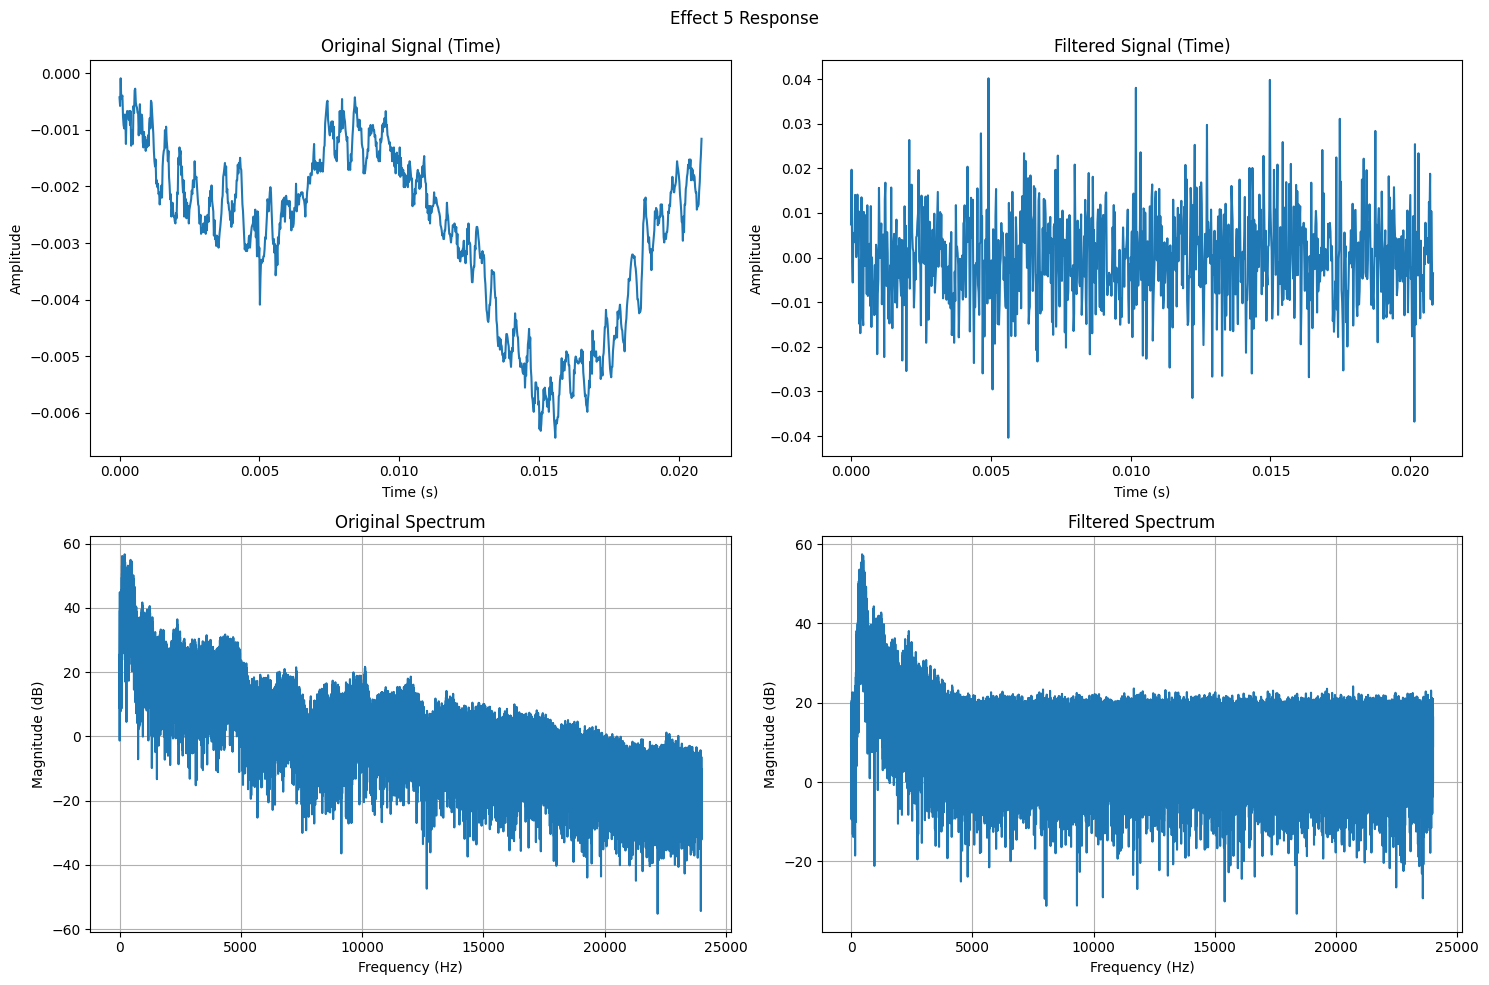

In [18]:
if __name__ == "__main__":
    SCRIPT_DIR = os.getcwd()
    INPUT_WAV = os.path.join(SCRIPT_DIR, "Audio_Effects.wav")
    OUTPUT_WAV = os.path.join(SCRIPT_DIR, "effected_output.wav")
    
    sample_rate, audio = wavfile.read(INPUT_WAV)
    original_dtype = audio.dtype

    audio_f32 = _to_float32(audio)
    fx = SimpleAudioFilters(sample_rate)

    print("What type of filter do you want?\n" \
    "Echo Effect (0)\n" \
    "Pitch Shift (1)\n" \
    "Tremolo Effect (2)\n" \
    "Ring Modulation (3)\n" \
    "Hard Clipping Distortion (4)\n" \
    "Telephone Filter (5)\n")

    answer = int(input("Enter a number (0-5): ").strip())
    chosen_effect = None
    if answer == 0:
        delay = int(input("What should be the delay in millisecons?"))
        chosen_effect = lambda x: fx.echo_effect(x, delay_ms=delay)
    elif answer == 1:
        factor = float(input("What should be the pitch factor?"))
        chosen_effect = lambda x: fx.pitch_shift(x, pitch_factor=factor)
    elif answer == 2:
        rate = int(input("What should be the rate?"))
        depth = float(input("What should be the depth?"))
        chosen_effect = lambda x: fx.tremolo_effect(x, rate=rate, depth=depth)
    elif answer == 3:
        freq = int(input("What should be the carrier frequency?"))
        chosen_effect = lambda x: fx.ring_modulation(x, carrier_freq=freq)
    elif answer == 4:
        threshold = float(input("What should be the distortion threshold?"))
        chosen_effect = lambda x: fx.hard_clipping(x, threshold=threshold)  
    elif answer == 5:
        chosen_effect = lambda x: fx.telephone_filter(x)  

    if chosen_effect is None:
        raise ValueError("Invalid choice. Please run again and enter a number 0–5.")

    processed = _apply_channelwise(chosen_effect, audio_f32)

    peak = np.max(np.abs(processed))
    if peak > 1.0:
        processed = processed / peak * 0.99

    wavfile.write(OUTPUT_WAV, sample_rate, _from_float32(processed, dtype=np.int16))
    print(f"Done. Wrote: {OUTPUT_WAV}")
    plot_filter_response(audio_f32 if audio_f32.ndim == 1 else audio_f32[:,0],
                     processed if processed.ndim == 1 else processed[:,0],
                     sample_rate,
                     title=f"Effect {answer} Response")

In [ ]:
Audio("Audio_Effects.wav")

In [ ]:
Audio("effected_output.wav")